# The Transformer Architecture

Transformers were introduced in the seminal paper “Attention is all you need” by
Vaswani et al.2 The gist of the paper is right there in the title: as it turned out, a simple
mechanism called “neural attention” could be used to build powerful sequence mod-
els that didn’t feature any recurrent layers or convolution layers.

<br>


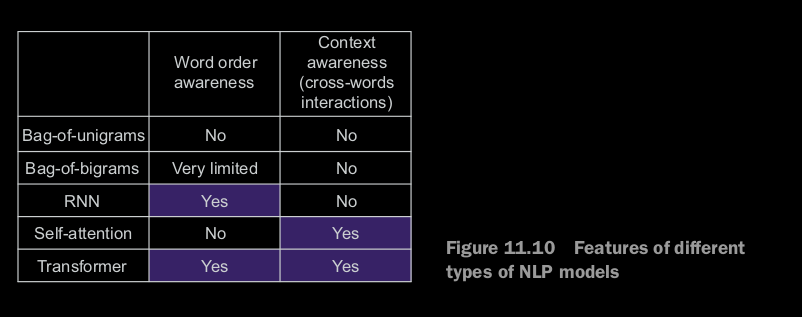


## Understanding self-attention


There are many different forms of attention you could imagine, but they all start by com-
puting importance scores for a set of features, with higher scores for more relevant fea-
tures and lower scores for less relevant ones. How these scores should be
computed, and what you should do with them, will vary from approach to approach.


The purpose of self-attention is to modulate the representation of a token
by using the representations of related tokens in the sequence. This produces context-
aware token representations.


Consider an example sentence: ```“The train left the station on time.”``` Now, consider one word in the sentence: ```station```. What kind of station
are we talking about? Could it be a radio station? Maybe the International Space Sta-
tion? Let’s figure it out algorithmically via self-attention.

<br>

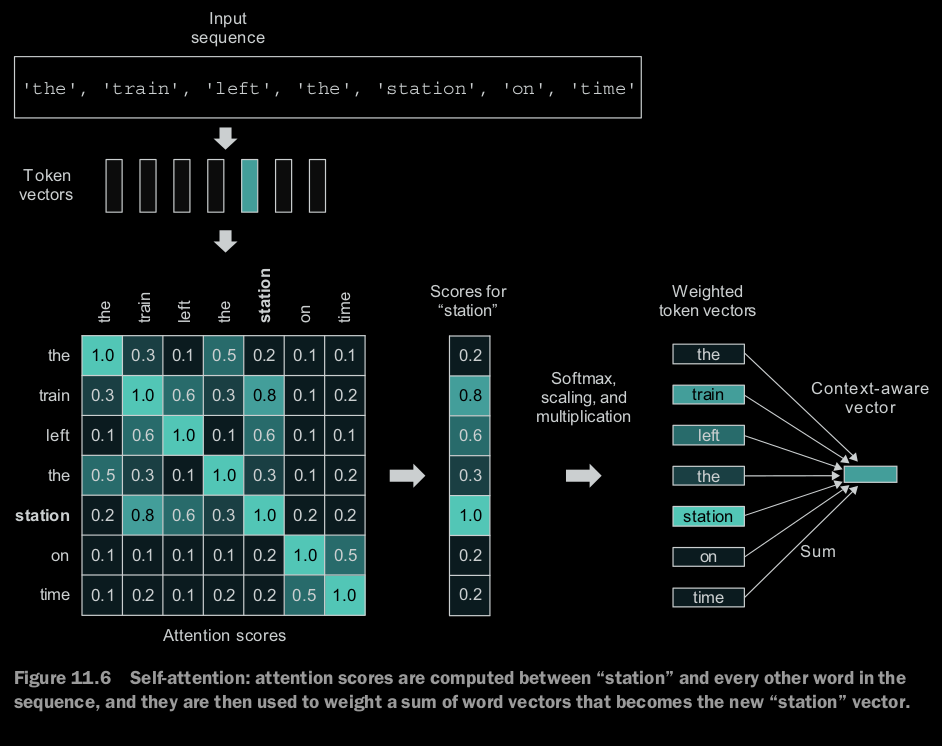


<br>

 - Step 1 is to compute relevancy scores between the vector for “station” and every other
word in the sentence. These are our “attention scores.” We’re simply going to use the
dot product between two word vectors as a measure of the strength of their relation-
ship. It’s a very computationally efficient distance function, and it was already the stan-
dard way to relate two word embeddings to each other long before Transformers. In
practice, these scores will also go through a scaling function and a softmax, but for
now, that’s just an implementation detail.


 - Step 2 is to compute the sum of all word vectors in the sentence, weighted by our
relevancy scores. Words closely related to “station” will contribute more to the sum
(including the word “station” itself), while irrelevant words will contribute almost
nothing. The resulting vector is our new representation for “station”: a representation
that incorporates the surrounding context. In particular, it includes part of the “train”
vector, clarifying that it is, in fact, a “train station.”

In [ ]:
def self_attention(input_sequence) :
  output = np.zeros(shape=input_sequence.shape)
  # iterarte over each token in the sequuence
  for i , pivot_vector in enumerate(input_sequence):

    scores = np.zeros(shape=(len(input_sequence) ,))

    for j , vector in enumerate(input_sequence):
      # compute the attention score dot of the vector and every other vectors
      scores[j] = np.dot(pivot_vector, vector.T)

    scores /= np.sqrt(input_sequence.shape[i])
    scores = softmax(scores)

    new_pivot_representation = np.zeros(shape=pivot_vector.shape)
    for j , vector in enumerate(input_sequence):
      new_pivot_representation += vector * scores[j]

    output[i] = new_pivot_representation

  return output 

In [ ]:
num_heads = 4
embed_dim = 256
mha_layer = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
outputs = mha_layer(inputs, inputs, inputs)



## GENERALIZED SELF-ATTENTION: THE QUERY-KEY-VALUE MODEL

the Transformer archi-
tecture was originally developed for machine translation, where you have to deal with
two input sequences: the source sequence you’re currently translating (such as “How’s
the weather today?”), and the target sequence you’re converting it to (such as “¿Qué
tiempo hace hoy?”).


Now let’s take a step back. The self-attention mechanism as we’ve introduced it
performs the following, schematically:

``` outputs = sum(inputs * pairwise_scores(inputs, inputs)) ```

</br>

This means “for each token in inputs (A), compute how much the token is related to
every token in inputs (B), and use these scores to weight a sum of tokens from
inputs (C).”

</br>

In the general case, you could be doing this with three different
sequences. We’ll call them “query,” “keys,” and “values.” The operation becomes “for
each element in the query, compute how much the element is related to every key,
and use these scores to weight a sum of values”:


``` outputs = sum(values * pairwise_scores(query, keys)) ```



### Multi-head attention

“Multi-head attention” is an extra tweak to the self-attention mechanism, introduced
in “Attention is all you need.” The “multi-head” moniker refers to the fact that the
output space of the self-attention layer gets factored into a set of independent sub-
spaces, learned separately.


the initial query, key, and value are sent through three
independent sets of dense projections, resulting in three separate vectors. Each vector
is processed via neural attention, and the three outputs are concatenated back
together into a single output sequence. Each such subspace is called a “head.”

<br>

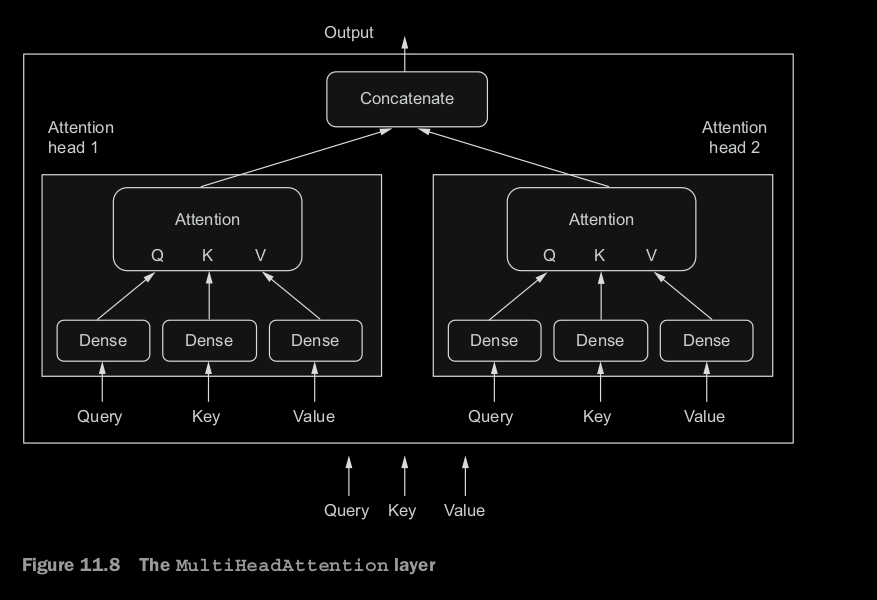

### The Transformer encoder

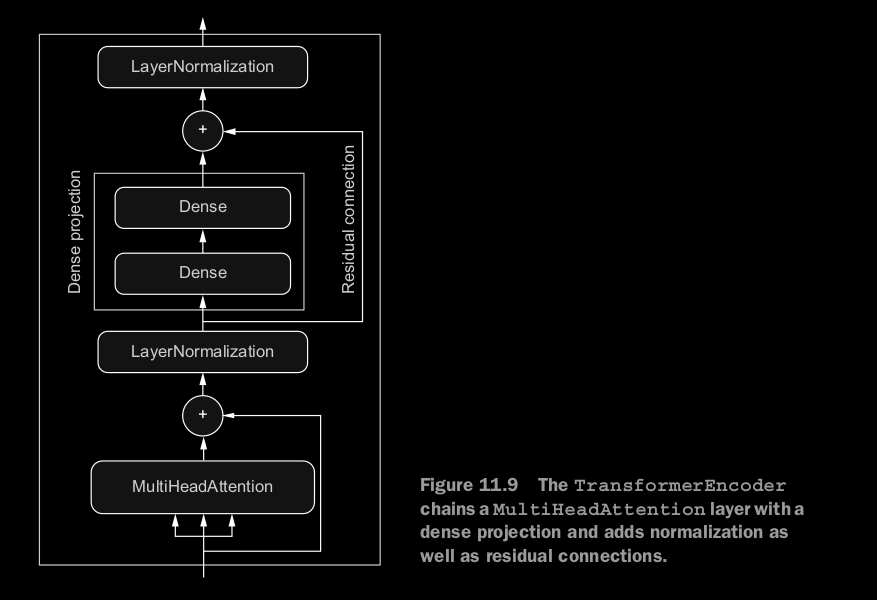

The original Transformer architecture consists of two parts: a Transformer encoder that
processes the source sequence, and a Transformer decoder that uses the source sequence
to generate a translated version.



#### Preparing the Data

In [3]:
from tensorflow.keras.layers import TextVectorization

In [2]:
#Let’s start by downloading the dataset from the Stanford page of Andrew Maas and
#uncompressing it:

!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  11.4M      0  0:00:07  0:00:07 --:--:-- 15.6M


In [3]:
'''
 You’re left with a directory named aclImdb, with the following structure:


aclImdb/
...train/
......pos/
......neg/
...test/
......pos/
......neg/ 


For instance, the train/pos/ directory contains a set of 12,500 text files, each of which
contains the text body of a positive-sentiment movie review to be used as training data.
The negative-sentiment reviews live in the “neg” directories. In total, there are 25,000
text files for training and another 25,000 for testing.
There’s also a train/unsup subdirectory in there, which we don’t need. Let’s

delete it:
'''
!rm -r aclImdb/train/unsup

In [4]:
''' Take a look at the content of a few of these text files. Whether you’re working with
text data or image data, remember to always inspect what your data looks like before
you dive into modeling it. It will ground your intuition about what your model is actu-
ally doing:
 '''
!cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

In [5]:
#Next, let’s prepare a validation set by setting apart 20% of the training text files in a
#new directory, aclImdb/val:


import os , pathlib , shutil , random

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"

for category in ("neg", "pos"):
  os.makedirs(val_dir / category)
  files = os.listdir(train_dir / category)
  random.Random(1337).shuffle(files)
  num_val_samples = int(0.2 * len(files))
  val_files = files[-num_val_samples:]
  for fname in val_files:
    shutil.move(train_dir / category / fname ,
                val_dir / category /fname)



In [1]:
#Let’s create three Dataset objects for training, validation, and testing:


from tensorflow import keras
batch_size = 32 

train_ds = keras.utils.text_dataset_from_directory(
"aclImdb/train", batch_size=batch_size )

val_ds = keras.utils.text_dataset_from_directory(
"aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
"aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [7]:
for inputs , targets in train_ds:
  print("Input shape :", inputs.shape)
  print("inputs.dtype:", inputs.dtype)
  print("targets.shape:", targets.shape)
  print("targets.dtype:", targets.dtype)
  print("inputs[0]:", inputs[0])
  print("targets[0]:", targets[0])
  break

Input shape : (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b'This is, without doubt, one of the worst films I\'ve ever seen...<br /><br />The plot is so full of holes, the story is like a bad remake of a bad suspense movie and the actors sound like were reading directly from the manuscript for the first time. Worst of all is Steve Guttenberg. He plays his character like he was in "Police Academy" - the same foolish womanizer - and that\'s not suited for a leading man in what should have been a thriller.<br /><br />It\'s really hard to believe that Hanson would make "L.A. Confidential" ten years later...<br /><br />Avoid this like the plague...', shape=(), dtype=string)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


In [4]:
text_vectorization = TextVectorization(
    max_tokens=20000,
    output_mode = "multi_hot",
)

text_only_train_ds = train_ds.map(lambda x, y :x) 
text_vectorization.adapt(text_only_train_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [5]:
text_vectorization.adapt(text_only_train_ds)


int_train_ds = train_ds.map(
lambda x, y: (text_vectorization(x), y),
num_parallel_calls=4)

int_val_ds = val_ds.map(
lambda x, y: (text_vectorization(x), y),
num_parallel_calls=4)

int_test_ds = test_ds.map(
lambda x, y: (text_vectorization(x), y),
num_parallel_calls=4)

#### Transformer encoder implemented as a subclassed **Layer**

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim  # Size of the input token vectors
        self.dense_dim = dense_dim  # Size of the inner dense layer
        self.num_heads = num_heads  # Number of attention heads

        # Multi-head attention layer
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)

        # Dense layers for projecting the output of the attention layer
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])

        # Layer normalization layers
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    # Computation goes in call().
    def call(self, inputs, mask=None):
        if mask is not None:
            # The mask that will be generated by the Embedding layer will be 2D, but
            # the attention layer expects to be 3D or 4D, so we expand its rank.
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)

        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config


In [8]:
vocab_size = 20000
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         5120000   
                                                                 
 transformer_encoder (Transf  (None, None, 256)        543776    
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257   

In [16]:
callbacks = [keras.callbacks.ModelCheckpoint("transformer_encoder.keras",save_best_only=True)]

tf.keras.backend.clear_session()
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20,callbacks=callbacks)

In [ ]:
model = keras.models.load_model("transformer_encoder.keras",custom_objects={"TransformerEncoder": TransformerEncoder})


print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

#### Saving custom layers

When you write custom layers, make sure to implement the get_config method: this
enables the layer to be reinstantiated from its config dict, which is useful during
model saving and loading. The method should return a Python dict that contains the
values of the constructor arguments used to create the layer.

All Keras layers can be serialized and deserialized as follows:

```
config = layer.get_config()
new_layer = layer.__class__.from_config(config)
```

For instance :

```
layer = PositionalEmbedding(sequence_length, input_dim, output_dim)
config = layer.get_config()
new_layer = PositionalEmbedding.from_config(config)
```

When saving a model that contains custom layers, the savefile will contain these con-
fig dicts. When loading the model from the file, you should provide the custom layer
classes to the loading process, so that it can make sense of the config objects:

```
model = keras.models.load_model(
filename, custom_objects={"PositionalEmbedding": PositionalEmbedding})
```

#### USING POSITIONAL ENCODING TO RE-INJECT ORDER INFORMATION


The original “Attention is all you need” paper used an interesting trick to encode
word positions: it added to the word embeddings a vector containing values in the
range [-1, 1] that varied cyclically depending on the position (it used cosine func-
tions to achieve this). This trick offers a way to uniquely characterize any integer in a
large range via a vector of small values. It’s clever, but it’s not what we’re going to use
in our case. We’ll do something simpler and more effective: we’ll learn position-
embedding vectors the same way we learn to embed word indices. We’ll then proceed
to add our position embeddings to the corresponding word embeddings, to obtain a
position-aware word embedding. This technique is called “positional embedding.”
Let’s implement it.

In [9]:
# Implementing positional embedding as a subclassed layer

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim,
            output_dim=output_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length,
            output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config


#### PUTTING IT ALL TOGETHER: A TEXT-CLASSIFICATION TRANSFORMER

In [10]:
vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posit  (None, None, 256)        5273600   
 ionalEmbedding)                                                 
                                                                 
 transformer_encoder_1 (Tran  (None, None, 256)        543776    
 sformerEncoder)                                                 
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                           

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",save_best_only=True)]

model.fit(int_train_ds, validation_data=int_val_ds, epochs=20,callbacks=callbacks)

## When to use sequence models over bag-of-words models

It turns out that when approaching a new text-classification task, you should pay
close attention to the ratio between the number of samples in your training data and
the mean number of words per sample (see figure 11.11). If that ratio is small—less
than 1,500—then the bag-of-bigrams model will perform better (and as a bonus, it will
be much faster to train and to iterate on too). If that ratio is higher than 1,500, then
you should go with a sequence model. In other words, sequence models work best
when lots of training data is available and when each sample is relatively short.


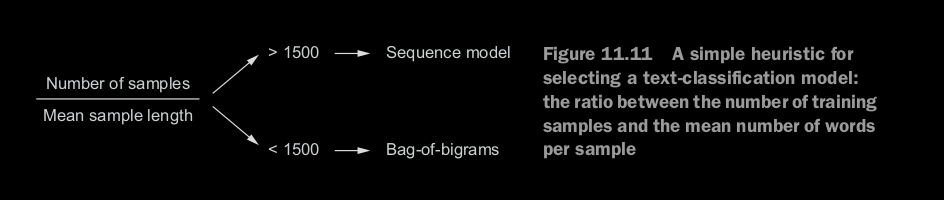



So if you’re classifying 1,000-word long documents, and you have 100,000 of them (a
ratio of 100), you should go with a bigram model. If you’re classifying tweets that are
40 words long on average, and you have 50,000 of them (a ratio of 1,250), you should
also go with a bigram model. But if you increase your dataset size to 500,000 tweets (a
ratio of 12,500), go with a Transformer encoder. What about the IMDB movie review
classification task? We had 20,000 training samples and an average word count of 233,
so our rule of thumb points toward a bigram model, which confirms what we found
in practice.

## References

 - [Deep Learning with python 2nd edition - Francois Chollet](https://www.manning.com/books/deep-learning-with-python)